# Customer Churn – Model Comparison

## 1. Problem Statement
## 2. Dataset Overview & Preprocessing
## 3. Baseline Model - Logistic Regression
## 4. Advanced Model 1 - Random Forest
## 5. Advanced Model 2 - Gradient Boosting
## 6. Model Performance Comparison
## 7. Model Explainability with SHAP


# 1. Problem Statement - Use a telecom customer Churn dataset to train different models (logistic regression, Random Forest, Gradient Boosting) and compare their performance. Based on the model evaluation and the industry relevance, recommend the most suitable model and use it to predict whether a customer is likely to churn. Based on this prediction, the business can take actions such as offering discounts or follow-ups.

# 2. Dataset Overview and Preprocessing - The dataset is a Telco Customer Churn Dataset from Kaggle. It consists of data from 7043 customers with each customer having 20 features. The output label 'Churn' shows whether that customer has churned or not.

Let's load the dataset using pandas

In [46]:
import pandas as pd

df = pd.read_csv("data/telco_churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


This is the raw data. It needs to be pre-processed before model training. We will apply below pre-processing step by step -

1 - Remove Identifiers - Remove the Customer Identifiers since they dont carry any predictive signal and may lead to model overfitting

In [47]:
df = df.drop(columns=['customerID'])

2 - Data Separation - Next, we will separate the data into input feature matrix X and target label matrix Y

In [48]:
X = df.drop(columns=['Churn'])
y = df['Churn'].map({'Yes': 1, 'No': 0})

3 - Data Conversion - we need to convert categorical data into one hot coded format so that the model can understand it. Also, we would apply scaling to numeric data so that the gradient based models converge faster and behave more stably. For example, 'Contract' field can take three possible values so it can be represented by 3 bits. We will use Scikit-learn pipelines for this

In [49]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Identify Feature Types-

In [50]:
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

We see an issue here - The feature 'TotalCharges' contains some empty cells which makes pandas consider it as an 'object' type rather than numeric. This is because during the data frame creation, pandas tried to convert it to numeric based on the majority of data values but due to these empty values it cannot do so. So it left the column as object type.

Fix for this issue - 
Force explicit numeric conversion. This converts valid numers correctly and invalid numbers to NaN

In [51]:
X['TotalCharges'] = pd.to_numeric(X['TotalCharges'], errors='coerce')

Impute NaN to 0 values

In [52]:
X['TotalCharges'] = X['TotalCharges'].fillna(0)

Reidentify Feature Types and verify if correct types were identified

In [53]:
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
print(categorical_cols)
print(numeric_cols)

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')
Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')


Now Lets Build the Data Preprocessong Pipeline

In [54]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)


Get the transformed data

In [55]:
X_processed = preprocessor.fit_transform(X)
type(X_processed)
X_processed[0]

array([-0.43991649, -1.27744458, -1.16032292, -0.99261052,  1.        ,
        0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ])

In [56]:
feature_names = preprocessor.get_feature_names_out()

In [57]:
X_inspect = pd.DataFrame(
    X_processed,
    columns=feature_names
)

X_inspect.iloc[0]

num__SeniorCitizen                             -0.439916
num__tenure                                    -1.277445
num__MonthlyCharges                            -1.160323
num__TotalCharges                              -0.992611
cat__gender_Female                              1.000000
cat__gender_Male                                0.000000
cat__Partner_No                                 0.000000
cat__Partner_Yes                                1.000000
cat__Dependents_No                              1.000000
cat__Dependents_Yes                             0.000000
cat__PhoneService_No                            1.000000
cat__PhoneService_Yes                           0.000000
cat__MultipleLines_No                           0.000000
cat__MultipleLines_No phone service             1.000000
cat__MultipleLines_Yes                          0.000000
cat__InternetService_DSL                        1.000000
cat__InternetService_Fiber optic                0.000000
cat__InternetService_No        

Preprocessing Output Observation - After applying preprocessing pipelines, the numerical features are standardized and the categorical features are one hot encoded providing us with a numerical matrix. This is a consistent input format for downstream ML models

Data Splitting - Since our goal is model evaluation, lets split the available data into training (80%) and test set(20%). This will help us tune model parameters, compare different models and report a model's performance. Scikit learn has a function that makes it easier

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_processed,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Data Leakage - There is a big problem with this approach named as Data Leakage. Since I have already scaled my data above based on the entire dataset, the information has leaked from the test data to training data. We should keep the train and test data as totally separate entities and the model should see the test data exactly once during evaluation.


Lets look at the correct approach below -

Take the initial feature set X and output label data set y and first split them into Training and Test sets

Train/Test Split the unscaled data

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 3. Baseline Mode - Logistic Regression

Create a Logistic Regression Pipeline

In [60]:
from sklearn.linear_model import LogisticRegression

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

Train the model on Training Data

In [61]:
model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

A question arises here - How do you know gradient descent converged if you can’t see the loss?
Ans - In practice, convergence is determined by solver tolerance and parameter stability. I monitor convergence warnings, check coefficient stability across iterations, and ensure cross-validation performance is stable.

In [62]:
y_predict_test = model.predict(X_test)


matches = y_predict_test == y_test
accuracy = matches.mean()

print(accuracy)

0.7381121362668559


We can see that our model is about 73% accurate on test set. Lets check the accuracy on training set

In [63]:
y_predict_train = model.predict(X_train)


matches = y_predict_train == y_train
accuracy = matches.mean()

print(accuracy)

0.7527511537096202


We can see that our model is about 75% accurate on training set. 

A question arises here - What degree polynomial was our logistic regression ?
A - It’s a linear model. Unless we explicitly add polynomial features, logistic regression learns a degree-1 decision boundary.

Now, let us tune the regularization using CV

In [64]:
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100]
}

C = 0.01 (very strong regularization. Chances of underfitting the model),
C = 100 (very weak regularization. Chances of overfitting the model)

Lets setup Cross Validation

In [65]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)


We score on "Recall" because we prioritize catching churners even if it means a few false catches

Revisit the concepts of Precision & Recall - 

Precision - Out of all the Churn Predictions my model did, how many were correct? Or How precise is my model in finding churn ? (True Positive / Total Predicted Positive)

Recall - Out of all the customers that actually churned, how many were my model able to catch ? (True Positive / Total Actual Positive)

For churn prevention, we prioritize recall because missing a customer who is about to leave is more costly than offering retention incentives to a few extra customers.

In [66]:
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring='recall',
    n_jobs=-1
)

Run the search

In [67]:
grid.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step..._iter=1000))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'classifier__C': [0.01, 0.1, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displa

Inspect The Results

In [68]:
grid.best_params_

{'classifier__C': 1}

In [69]:
results = pd.DataFrame(grid.cv_results_)

results[['param_classifier__C', 'mean_test_score', 'std_test_score']]

,param_classifier__C,mean_test_score,std_test_score
0,0.01,0.789967,0.032796
1,0.10,0.797993,0.033883
2,1.00,0.801338,0.037933
3,10.00,0.800000,0.037921
4,100.00,0.800669,0.036977


We trained multiple versions of the churn model with different levels of complexity. Each version was validated on multiple realistic customer samples to ensure consistency. We selected the configuration that best identifies customers at risk of churn while remaining stable and generalizable.

In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



This tells us that our model is doing well in -
--> Has a strong Churn Recall (78 %)
--> Has minimal overfitting
--> Stable Performance
--> Good Baseline Model


What it does not do well in - 
--> Moderate Churn Precision
--> Has linear decision boundary

Logistic Regression serves as a strong interpretable baseline


# 4. Advance Model 1 - Random Forest - Now since we have a baseline model working, lets use a more advance model called Random Forest to see if we can get improvements in Recall metric.

We use the same preprocessing Pipeline and data split as earlier. Lets build the random forest model pipeline

In [71]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

Train the random forest model on our training set

In [72]:
rf_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

Evaluate how the random forest performs on the test data

In [73]:
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1035
           1       0.54      0.77      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409



Now, lets compare the classification results from both the logistic regression and random forest algorithms - 

Logistic Regression - 

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409


Random Forest - 

              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1035
           1       0.54      0.77      0.63       374

    accuracy                           0.76      1409



Lets focus on the Churn (1) class. We get below observations - 

Precision improves slightly from 0.50 to 0.54
Recall is essentially the same 0.78 vs 0.77

Random Forest did not discover significantly more churners than the linear model. However, sine the precision has improved the sales / retention teams waster less effort on customers who wont churn


What this tells us about the data ? - The churn signal in this dataset is largely linear, and Logistic Regression already captured most of it.

Summarize - 

If the goal is maximum churn capture, Logistic Regression is already sufficient

If the goal is operational efficiency, Random Forest is better

--> Same recall

--> Fewer false positives


# 5. Advance Model 2 - Gradient Boosting - Gradient Boosting is another ensemble tree method based on sequential Tree Training. It builds trees sequentially to correct previous errors, whereas Random Forest builds independent trees in parallel.

Now we use the Gradient Boosting Model and observe its performance metrics on our data. First lets create the model pipeline

In [74]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

Next, lets train our Gradient Boosting model

In [75]:
gb_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

Evaluate the GB Model Performance 

In [76]:
y_pred_gb = gb_model.predict(X_test)
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



## 6. Final Model Comparison

The table below compares the performance of three different models on the customer churn dataset.
While overall accuracy is important, special attention is given to **recall for the churn class**, since
missing a churner has a higher business cost than a false positive.

| Model                | Accuracy | Churn Recall | Churn Precision | Churn F1 |
|---------------------|----------|--------------|-----------------|----------|
| Logistic Regression | 0.74     | 0.78         | 0.50            | 0.61     |
| Random Forest       | 0.76     | 0.77         | 0.54            | 0.63     |
| Gradient Boosting   | 0.80     | 0.52         | 0.67            | 0.59     |

**Observation:**  
Gradient Boosting achieves the highest overall accuracy and precision, while Logistic Regression and Random Forest
provide better recall for churners. The final model choice depends on whether the business prioritizes
**catching as many churners as possible (recall)** or **reducing false alarms (precision)**.

# 7. Model Explainability with SHAP

SHAP Analysis helps understand the impact of each feature in a prediction

Import SHAP in your notebook

In [77]:
import shap
import matplotlib.pyplot as plt

Create SHAP Explainer (Tree-Based)

In [78]:
X_transformed = preprocessor.transform(X_test)

explainer = shap.TreeExplainer(gb_model.named_steps['classifier'])
shap_values = explainer.shap_values(X_transformed)

feature_names = preprocessor.get_feature_names_out()


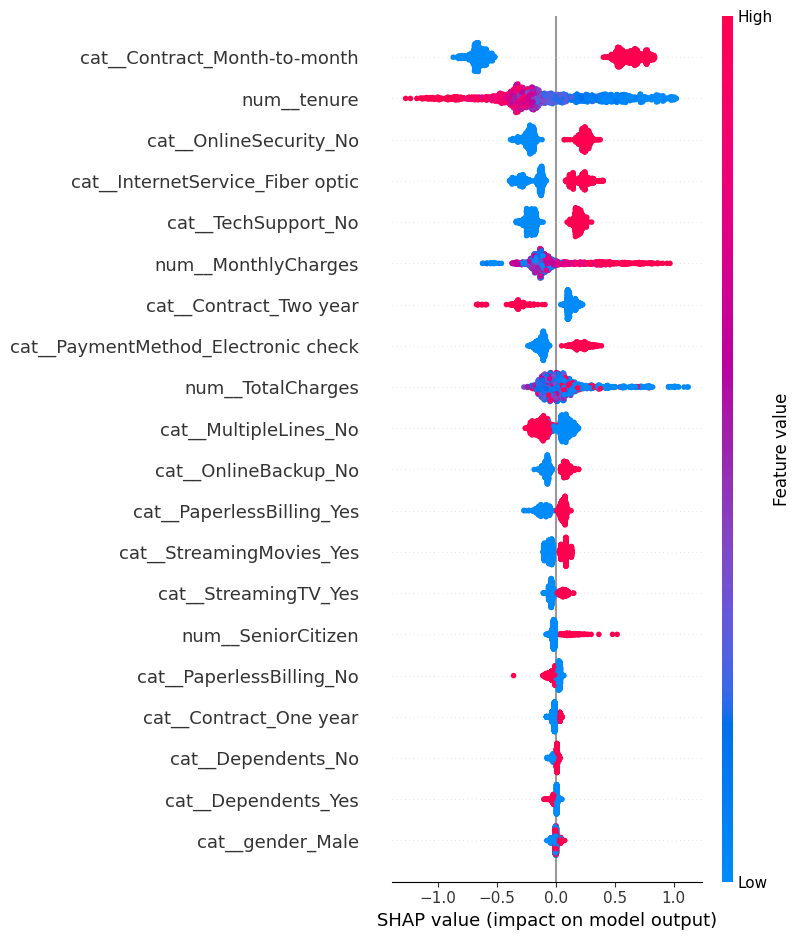

<Figure size 640x480 with 0 Axes>

In [79]:
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)
plt.savefig("images/shap_summary.png", bbox_inches="tight")

This helps us answer the question --> "What features drive churn in general" ?

Lets look at the top 5 features and try to interpret them based on the SHAP summary plot - 

**Cat_Contract_Month-to-Month - This is the most important feature. Having a month-to-month contract increases churn probability, not having month-to-month contract decreases churn.
**num_tenure - This is tricky to interpret from the SHAP plot. The plot tells us that the customers with shorter tenure are more likely to churn
**Cat_Online_Security_No - Customers with no online security are more likely to churn
**Cat_Internet_Service_Fiber_Optic - Customers with Fiber Optic Internet Service are more likely to churn
**cat_TechSupport_No - No Tech Support Increases Churn Probability


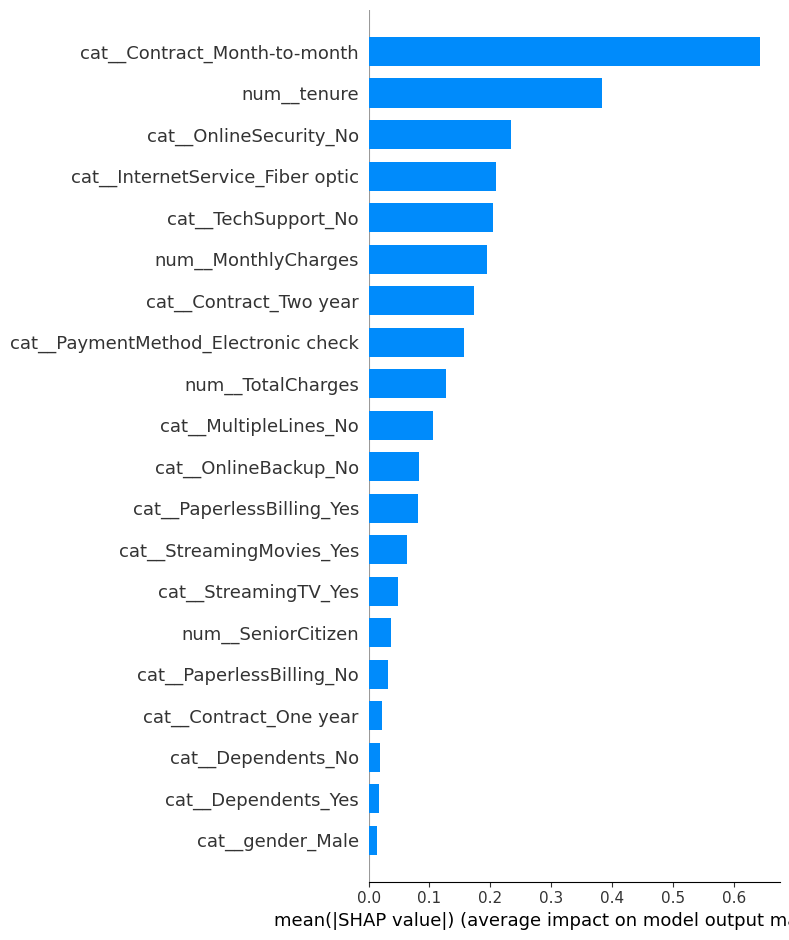

In [80]:
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names, plot_type="bar")

In [81]:
plt.savefig("images/shap_feature_importance.png", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

Lets also look at the SHAP Analysis from one customer perspective

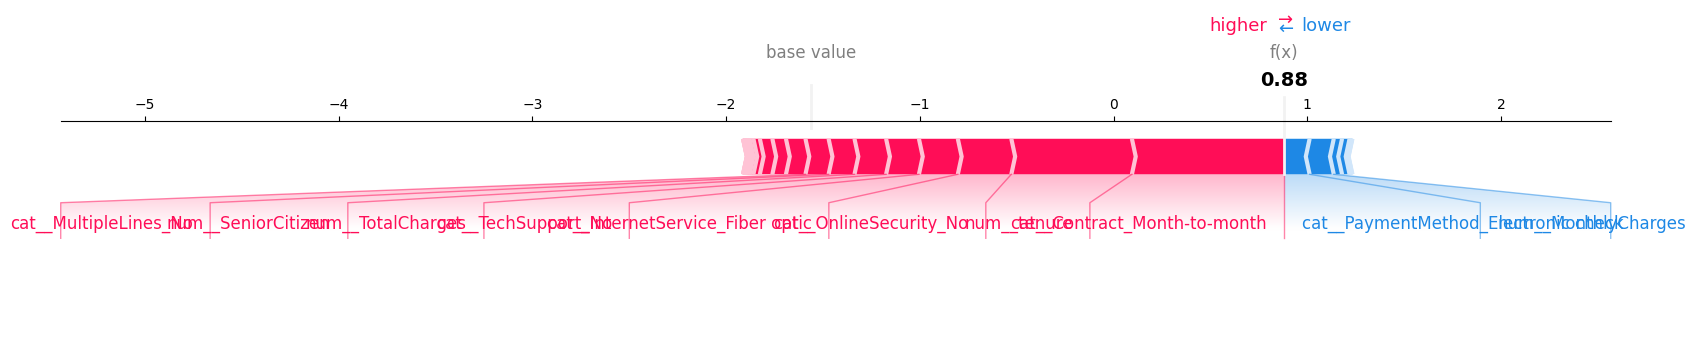

In [92]:
customer_index = 20 # Pick a customer

shap.force_plot(
    explainer.expected_value,
    shap_values[customer_index],
    feature_names=feature_names,
    matplotlib=True
)


This customer is predicted to churn mainly due to contract type being month to month and shorter tenure whereas Payment method slightly reduces the churn risk

### Key Insights from SHAP Analysis

- Contract Type and Tenure Length are the strongest drivers of Churn
- Customers with month to month contract type are significantly more likely to churn 
- Longer tenure reduces churn probability


### Individual Customer Explanation

- We saw that for a particular customer, contract type as month to month and shorter tenure are the strongest drivers of churn